In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

train_data, train_labels = read_data("sample_train.csv")
test_data, test_labels = read_data("sample_test.csv")
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)

(6000, 784) (1000, 784)
(6000,) (1000,)


## Linear Transformation
---
### First
Multiplying data by a orthogonal matrix

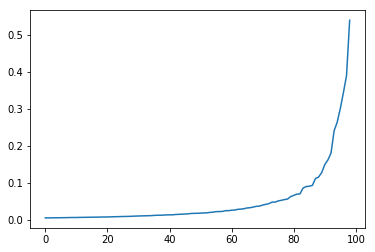

In [4]:
# Experimental validation here.
# Multiply your data (train_data) with an orthonormal matrix and plot the
# eigen value specturm of the new covariance matrix.

# code goes here
from numpy import linalg as LA
import matplotlib.pyplot as plt
n = 784
H = np.random.randint(0,300,size=(784,784))
q, r = np.linalg.qr(H)
newtrain_data = []
for i in range(0,6000):
    newtrain_data.append(np.matmul(q, train_data[i,:]))
matrix=np.matrix(newtrain_data)
covar=np.cov(matrix, rowvar= False)
eigv, ev= LA.eig(covar)
index=np.argsort(eigv[0:99])
plt.plot(np.array(eigv[0:99].real)[index]/LA.norm(eigv[0:99]))
plt.show()

### Second
Project the original data into the first and second eigenvectors and plot in 2D

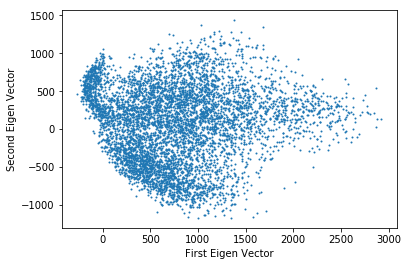

In [5]:
# Plotting code here
from numpy import linalg as LA
import matplotlib.pyplot as plt
array=[]
for i in range(0,6000):
    array.append(train_data[i,:])
matrix=np.matrix(array)
covar=np.cov(matrix, rowvar=False)
eigv, ev= LA.eig(covar)
x=[]
y=[]
for i in range(0,6000):
    x.append(np.matmul(train_data[i,:], ev[:,np.argsort(eigv)[783]].real))
    y.append(np.matmul(train_data[i,:], ev[:,np.argsort(eigv)[782]].real))
plt.scatter(x,y,s=1)
plt.xlabel('First Eigen Vector')
plt.ylabel('Second Eigen Vector')
plt.show()

## Probabilistic View
---
In this section I will classify the test set by fitting multivariate gaussians on the train set, with different choices for decision boundaries. On running, the code should print the accuracy on the test set.

### MLP

In [6]:
# Print accuracy on the test set using MLE
from numpy import linalg as LA
from numpy.linalg import inv
def gauss(mean, cov):
    eigv, ev= LA.eig(cov)
    rank=np.linalg.matrix_rank(cov)
    V=np.matmul(np.matmul(ev[:,0:rank].real,inv(np.diag(eigv[0:rank].real))),ev[:,0:rank].real.transpose())
    power=-((np.log(np.pi*2)*rank)/2)-(np.sum(np.log(eigv[0:rank].real))/2)
    md=-(np.matmul(np.matmul((test_data-mean),V),(test_data-mean).transpose()))/2
    arr=np.diagonal(md)
    return power+arr
                               
all_means=np.array([np.mean(train_data[train_labels==i],axis=0) for i in range(0,10)])
all_cov=np.array([np.cov(train_data[train_labels==i],rowvar=False) for i in range(0,10)])
accuracy=0
mat=np.array([gauss(all_means[i],all_cov[i]) for i in range(0,10)])
for i in range(0,1000):
    if np.argmax(mat[:,i])==test_labels[i]:
        accuracy=accuracy+1
print(accuracy/10)

73.9


### MAP

In [7]:
# Print accuracy on the test set using MAP
# (assume a reasonable prior and mention it in the comments)
# Prior probability is 0.1
from numpy import linalg as LA
from numpy.linalg import inv
def gauss(mean, cov):
    eigv, ev= LA.eig(cov)
    rank=np.linalg.matrix_rank(cov)
    V=np.matmul(np.matmul(ev[:,0:rank].real,inv(np.diag(eigv[0:rank].real))),ev[:,0:rank].real.transpose())
    power=-(np.log(np.pi*2)*rank/2)-(np.sum(np.log(eigv[0:rank].real))/2)
    md=-(np.matmul(np.matmul((test_data-mean),V),(test_data-mean).transpose()))/2
    arr=np.diagonal(md)
    return power+arr+np.log(0.1)
                               
all_means=np.array([np.mean(train_data[train_labels==i],axis=0) for i in range(0,10)])
all_cov=np.array([np.cov(train_data[train_labels==i],rowvar=False) for i in range(0,10)])
accuracy=0
mat=np.array([gauss(all_means[i],all_cov[i]) for i in range(0,10)])
for i in range(0,1000):
    if np.argmax(mat[:,i])==test_labels[i]:
        accuracy=accuracy+1
print(accuracy/10)

73.9


### Bayesian Pairwaise Majority Voting Method

In [8]:
# Print accuracy using Bayesian pairwise majority voting method
from numpy import linalg as LA
from numpy.linalg import inv
def gauss(mean1,mean2, cov,index1,index2):
    final=np.zeros(1000)
    eigv, ev= LA.eig(cov)
    rank=np.linalg.matrix_rank(cov)
    V=np.matmul(np.matmul(ev[:,0:rank].real,inv(np.diag(eigv[0:rank].real))),ev[:,0:rank].real.transpose())
    power=-(np.log(np.pi*2)*392)-(np.sum(np.log(eigv[0:rank].real))/2)
    md1=-(np.matmul(np.matmul((test_data-mean1),V),(test_data-mean1).transpose()))/2
    md2=-(np.matmul(np.matmul((test_data-mean2),V),(test_data-mean2).transpose()))/2
    arr1=np.diagonal(md1)
    arr2=np.diagonal(md2)
    for i in range(0,1000):
        if arr1[i]>=arr2[i]:
            final[i]=index1
        else:
            final[i]=index2
    return final

all_means=np.array([np.mean(train_data[train_labels==i],axis=0) for i in range(0,10)])
all_cov=np.array([np.cov(train_data[train_labels==i],rowvar=False) for i in range(0,10)])
mat=np.zeros(1000)
accuracy=0
for i in range(0,10):
    for j in range(i+1,10):
        mat=np.vstack((mat,gauss(all_means[i],all_means[j],(all_cov[i]+all_cov[j])/2,i,j)))
mat=np.delete(mat,0,axis=0).astype(int)
for i in range(0,1000):
    if np.argmax(np.bincount(mat[:,i]))==test_labels[i]:
        accuracy=accuracy+1
print(accuracy/10)

83.5


###  Simple Perpendicular Bisector majority voting method

In [9]:
# Print accuracy using Simple Perpendicular Bisector majority voting method
from numpy import linalg as LA
def perpendicular(mean1,mean2,index1,index2):
    final=np.zeros(1000)
    first=LA.norm(test_data-mean1,axis=1)
    second=LA.norm(test_data-mean2,axis=1)
    for i in range(0,1000):
        if first[i]>=second[i]:
            final[i]=index2
        else:
            final[i]=index1
    return final
all_means=np.array([np.mean(train_data[train_labels==i],axis=0) for i in range(0,10)])
mat=np.zeros(1000)
accuracy=0
for i in range(0,10):
    for j in range(i+1,10):
        mat=np.vstack((mat,perpendicular(all_means[i],all_means[j],i,j)))
mat=np.delete(mat,0,axis=0).astype(int)
for i in range(0,1000):
    if np.argmax(np.bincount(mat[:,i]))==test_labels[i]:
        accuracy=accuracy+1
print(accuracy/10)

77.0


### Compare performances and salient observations
---


- MLE has a bad performance (accuracy = 73.9) since the estimation is based on the information received from the training set. The parameters $\mu$ and $\Sigma$ for the 2-D Gaussian curve are fixed based on the training set. The parameters are not tuned to any data from the test set. Therefore, as a result of overfitting on the training set/less generality, the accuracy is low. If the training set would have been a better representative of the overall distribution of data samples, accuracy would have been better for test set also.

Prior for MAP : $\frac{1}{10}$ as there are are 10 classes of digits and all digits are equally probable

- MAP has accuracy similar to MLE(accuracy = 73.9) due to similar reasons. The priori assumption does not have an affect on the accuracy since it gives equal probability to all classes.

- Pairwise bayesian method has the best accuracy (accuracy = 83.5) across all methods. It uses a common sigma value, and unique mean value for any pair of classes. This takes into consideration the means of the classes and also the covariance(though averaged), hence the spread of the data gets accounted for too. Doing a majority vote across all classes reduces error (in classification) as much as possible hence gaining more accuracy than MLE and MAP.

- Perpendicular bisector method has a little better performance (accuracy = 77) as compared to MLE and MAP but lesser than Pairwise bayesian method. Since it uses only distance of the mean point of every class, it does not incorporate sufficient information about the spread of the data in each class, as $\Sigma$ is not considered, hence has lesser accuracy than Pairwise Bayesian. Doing a majority vote across all classes reduces error (in classification) as much as possible hence gaining more accuracy than MLE and MAP.


## Nearest Neighbour based Classification
---
### NN Classification with various K
Implement a KNN classifier and print accuracies on the test set with K=1,3,7

In [10]:
# Print accuracies with K = 1, 3, 7
from numpy import linalg as LA
import numpy as np
def knn_call(train_data, test, K):
    distance=np.zeros(6000)
    for i in range(0,6000):
        distance[i]=LA.norm(train_data[i,:]-test)
    l = np.argsort(distance)[:K]
    dist_mat=np.array(train_labels)[l].astype(int)
    class_out=np.argmax(np.bincount(dist_mat))
    return class_out
    

neighbour=[1,3,7]
accuracy=[]
for j in range(0,len(neighbour)):
    true=0u
    for i in range(0,1000):
        if knn_call(train_data,test_data[i,:],neighbour[j])==test_labels[i]:
            true=true+1
    accuracy.append(true/10)
print(accuracy)        

[90.7, 91.6, 91.6]


### Analysis of accuracies for different K

The accuracies are different owing to the different position and the clustering of the images in the test set when compared to the training set. For higher K values we take more neighbours into account and hence arent completely dependent on the nearest neighbour. Graphically, our decision boundary will be more jagged as the small K would be blind to the overall distribution. On the other hand, a higher K averages more voters in each prediction and hence is more resilient to outliers. Larger values of K will have smoother decision boundaries.

We can identify the best K based on our understanding of the data, and a binary search approach. This is because the accuracy gets worse as we move away from K on either side. We can think of this similar to the underfitting/overfitting problem

### Reverse NN Based Outliers
A sample can be thought of as an outlier is it is NOT in the nearest neighbour set of anybody else. Expand this idea into an algorithm.

In [13]:
# This cell reads mixed data containing both MNIST digits and English characters.
# The labels for this mixed data are random and are hence ignored.
mixed_data, _ = read_data("outliers.csv")
print(mixed_data.shape)

(20, 784)


In [14]:
#Outliers are printed for K=19
from numpy import linalg as LA
import numpy as np
def knn_call(test, index):
    distance=np.zeros(6020)
    for i in range(0,6020):
        if i != index:
            distance[i]=LA.norm(new_set[i,:]-test)
        if i==index:
            distance[i]=10000000
    l = np.argsort(distance)[:K]
    unique= np.unique(l)
    for i in range(6000,6020):
        for j in range(0,unique.size):
            if unique[j]==i:
                outlier_list[i-6000]=outlier_list[i-6000]+1
    return outlier_list
    
K=19
outlier=[]
outlier_list=np.zeros(20)
new_set=np.concatenate((train_data,mixed_data))
for i in range(0,6000):
    knn_call(train_data[i,:],i)
for i in range(0,20):
    if(outlier_list[i]==0):
        outlier.append(i)
        

print(outlier)

[0, 4, 6, 9, 18]


### NN for regression
Assume that each classID in the train set corresponds to a neatness score as:
$$ neatness = \frac{classID}{10} $$

---
Assume we had to predict the neatness score for each test sample using NN based techiniques on the train set. The neatness score of each test sample can be calculated by taking the weighted mean of the labels in it's nearest neighbour set, where weigth is the inverse of distance between the test data and the data in it's nearest neighbour set. The nearest neighbour set is calculated similar to the kNN approach.

In [15]:
#absolute error
from numpy import linalg as LA
import numpy as np
def knn_call(train_data, test, K):
    distance=np.zeros(6000)
    class_out=0
    sum_deno=0
    for i in range(0,6000):
        distance[i]=LA.norm(train_data[i,:]-test)
    l = np.argsort(distance)[:K]
    dist_mat=np.array(train_labels/10)[l]
    for i in range(0,K):
        class_out=class_out+(dist_mat[i]/distance[i])
        sum_deno=sum_deno+(1/distance[i])
    final=class_out/sum_deno
    return final
    

neighbour=[1,3,7]
error=np.zeros(3)
for j in range(0,len(neighbour)):
    for i in range(0,1000):
        error[j]=error[j]+np.absolute((knn_call(train_data,test_data[i,:],neighbour[j])-(test_labels[i]/10)))
print(error/1000)        

[ 0.0354      0.03756709  0.04382258]
